In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import random

random.seed(741)

In [2]:
cases = pd.read_csv(r'C:\Users\MartinBirkAndreasen\Desktop\Jazz\QlikWorld\subscription\original_raw\customer_cases.csv', index_col=0)
product = pd.read_csv(r'C:\Users\MartinBirkAndreasen\Desktop\Jazz\QlikWorld\subscription\original_raw\customer_product.csv', index_col=0)
dim_customer = pd.read_csv(r'C:\Users\MartinBirkAndreasen\Desktop\Jazz\QlikWorld\subscription\original_raw\customer_info.csv', index_col=0)

# Generate more users:
- Generate customers in customer_cases
- Add the new customers to dim_customer and generate age, gender, 
- Add customer to products - Add created date. + Generate new cancelation month (after created date)


In [3]:
def add_random_days(date, t_0=60, t_1=120):
    if date.month > 7:
         new_date = date
    
    else:
        n = np.random.uniform(t_0,t_1)
        new_date = date + timedelta(days=n)

    return new_date


In [74]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [85]:
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2022-01-01')

random_date(start_date, end_date)

Timestamp('2019-06-19 05:19:50')

In [134]:
sample_size = 1000000

gen_cases = pd.DataFrame({
    'case_id' :  np.array(pd.Series(np.repeat("CC", sample_size)) + pd.Series(np.arange(330613, 330613+sample_size)).astype(str)),
    'date_time' : cases['date_time'].sample(sample_size, replace = True, random_state=741).to_numpy(),
    'customer_id' : np.array(pd.Series(np.repeat("C", sample_size)) + pd.Series(np.arange(511380, 511380+sample_size)).astype(str)),
    'channel' : cases['channel'].sample(sample_size, replace = True).to_numpy(),
    'reason' : cases['reason'].sample(sample_size, replace = True).to_numpy(),
    })


gen_cases['date_time'] = pd.to_datetime(gen_cases['date_time']).apply(lambda x: add_random_days(x, t_0=10, t_1=365*3))

late_lst = gen_cases[(gen_cases['date_time'] > pd.to_datetime('2021-12-12'))].index

gen_cases.iloc[late_lst, 1] = gen_cases.iloc[late_lst, 1].apply(lambda x: random_date(start_date, end_date)).copy()

gen_cases

,case_id,date_time,customer_id,channel,reason
0,CC330613,2018-04-14 00:17:39.000000,C511380,phone,support
1,CC330614,2021-09-16 13:18:44.000000,C511381,phone,signup
2,CC330615,2020-09-05 12:13:42.000000,C511382,phone,support
3,CC330616,2021-11-25 23:57:32.007846,C511383,phone,signup
4,CC330617,2018-11-23 21:48:28.000000,C511384,phone,signup
...,...,...,...,...,...
999995,CC1330608,2020-11-28 14:19:51.967062,C1511375,phone,support
999996,CC1330609,2021-08-03 16:50:19.000000,C1511376,phone,support
999997,CC1330610,2017-05-17 09:43:13.000000,C1511377,email,signup
999998,CC1330611,2018-07-17 00:29:29.100129,C1511378,phone,support


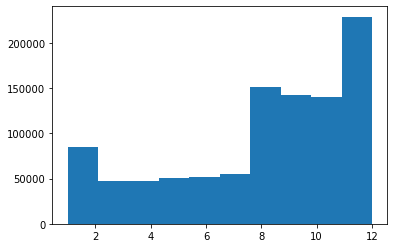

In [143]:
plt.hist(gen_cases['date_time'].dt.month)
plt.show()

In [144]:
gen_cust = pd.DataFrame({
    'customer_id' : np.array(pd.Series(np.repeat("C", sample_size)) + pd.Series(np.arange(511380, 511380+sample_size)).astype(str)),
    'age' : dim_customer['age'].sample(sample_size, replace = True).to_numpy(),
    'gender' : dim_customer['gender'].sample(sample_size, replace = True).to_numpy(),
    })


# Make old --> female
gen_cust[gen_cust['age']>=60].sample(np.int64(0.3*sample_size))['gender'] = 'female'


gen_cust

,customer_id,age,gender
0,C511380,68,male
1,C511381,57,male
2,C511382,60,male
3,C511383,48,male
4,C511384,55,female
...,...,...,...
999995,C1511375,57,male
999996,C1511376,72,male
999997,C1511377,57,male
999998,C1511378,63,male


In [145]:
def add_random_cancel_days(date, t_0=30, t_1=800):
    if date.month <= 2:
         new_date = date + timedelta(days=365)
    
    elif (date.year == 2020) & (date.month > 3) & (date.month < 8):    
        new_date = date + timedelta(days=10)

    elif (date.month > 2) & (date.month < 9):    
        new_date = date + timedelta(days=160)

    else:
        n = np.random.uniform(t_0,t_1)
        new_date = date + timedelta(days=n)

    return new_date


def short_cancel_days(date, t_0=30, t_1=200):
    n = np.random.uniform(t_0,t_1)
    new_date = date + timedelta(days=n)

    return new_date

In [151]:
gen_prod = gen_cases[['customer_id', 'date_time']].copy()

gen_prod['product'] = product['product'].sample(sample_size, replace = True).to_numpy()

gen_prod = gen_prod[['customer_id', 'product', 'date_time']].copy()

gen_prod['date_time'] = pd.to_datetime(gen_prod['date_time']) 

gen_prod['cancel_date_time'] = gen_prod['date_time'].apply(lambda x: short_cancel_days(x))

gen_prod = gen_prod.rename(columns={'date_time': 'signup_date_time'})

# Make old --> prd_2
gen_cust[gen_cust['age']>=60].sample(np.int64(0.3*sample_size))['product'] = 'prd_2'

# Make even shorter cancelation for some
selected_shorties = gen_prod[gen_prod['signup_date_time'] < pd.to_datetime('2021-01-27')]['customer_id']
gen_prod[gen_prod['customer_id'].isin(selected_shorties)]['cancel_date_time'] = gen_prod[gen_prod['customer_id'].isin(selected_shorties)]['signup_date_time'].apply(lambda x: short_cancel_days(x, t_0=5, t_1=365))

selected_shorties = gen_prod[(gen_prod['signup_date_time'] > pd.to_datetime('2021-01-27')) & (gen_prod['signup_date_time'] < pd.to_datetime('2022-01-27'))]['customer_id']
gen_prod[gen_prod['customer_id'].isin(selected_shorties)]['cancel_date_time'] = gen_prod[gen_prod['customer_id'].isin(selected_shorties)]['signup_date_time'].apply(lambda x: add_random_cancel_days(x, t_0=5, t_1=60))

gen_prod

C:\Users\MartinBirkAndreasen\AppData\Local\Temp\ipykernel_18936\1508119344.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_prod[gen_prod['customer_id'].isin(selected_shorties)]['cancel_date_time'] = gen_prod[gen_prod['customer_id'].isin(selected_shorties)]['signup_date_time'].apply(lambda x: short_cancel_days(x, t_0=5, t_1=365))
C:\Users\MartinBirkAndreasen\AppData\Local\Temp\ipykernel_18936\1508119344.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_prod[gen_prod['customer_id'].isin(select

,customer_id,product,signup_date_time,cancel_date_time
0,C511380,prd_2,2018-04-14 00:17:39.000000,2018-06-28 07:04:06.843573
1,C511381,prd_1,2021-09-16 13:18:44.000000,2022-02-03 13:33:02.962513
2,C511382,prd_2,2020-09-05 12:13:42.000000,2021-02-02 06:43:27.178043
3,C511383,prd_1,2021-11-25 23:57:32.007846,2022-01-10 08:54:35.412250
4,C511384,prd_1,2018-11-23 21:48:28.000000,2019-04-30 22:21:06.691606
...,...,...,...,...
999995,C1511375,prd_1,2020-11-28 14:19:51.967062,2021-04-13 09:04:45.839180
999996,C1511376,prd_2,2021-08-03 16:50:19.000000,2021-09-21 14:26:56.239452
999997,C1511377,prd_2,2017-05-17 09:43:13.000000,2017-07-29 19:27:25.002794
999998,C1511378,prd_1,2018-07-17 00:29:29.100129,2018-09-29 18:57:12.678565


# Merge original and generated data

In [152]:
new_cases = pd.concat([cases,gen_cases], ignore_index=True)
new_product = pd.concat([product,gen_prod], ignore_index=True)
new_dim_customer = pd.concat([dim_customer, gen_cust], ignore_index=True)

[]

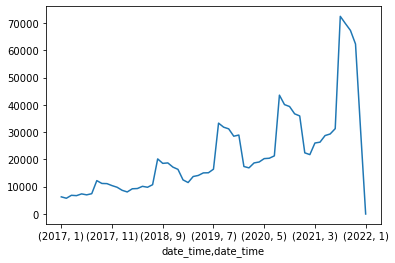

In [153]:
group = new_cases.groupby([pd.DatetimeIndex(new_cases['date_time']).year, pd.DatetimeIndex(new_cases['date_time']).month])['customer_id'].count()
group.plot(x = 'customer_id')
plt.plot()

[]

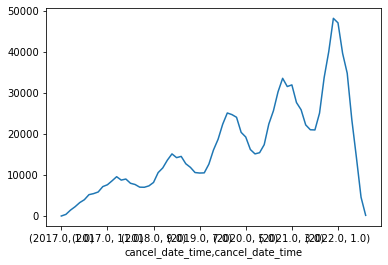

In [154]:

group2 = new_product.groupby([pd.DatetimeIndex(new_product['cancel_date_time']).year, pd.DatetimeIndex(new_product['cancel_date_time']).month])['customer_id'].count()
group2.plot(x = 'customer_id')
plt.plot()

# Save new data

In [155]:
new_cases.to_csv(r'C:\Users\MartinBirkAndreasen\Desktop\Jazz\QlikWorld\subscription\raw\customer_cases.csv', index=False, encoding='utf-8', sep=',')
new_product.to_csv(r'C:\Users\MartinBirkAndreasen\Desktop\Jazz\QlikWorld\subscription\raw\customer_product.csv', index=False, encoding='utf-8', sep=',')
new_dim_customer.to_csv(r'C:\Users\MartinBirkAndreasen\Desktop\Jazz\QlikWorld\subscription\raw\customer_info.csv', index=False, encoding='utf-8', sep=',')